In [1]:
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.model_selection import train_test_split

2025-07-14 07:51:44.782890: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 07:51:44.791658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752472304.802275    6761 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752472304.805326    6761 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752472304.813824    6761 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import os
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING
os.environ['ABSL_LOG_LEVEL'] = '3'        # Suppress absl logging

print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      print("Found GPU:", gpu)
    print(f"Avail GPU Num: {len(gpus)}")
  except RuntimeError as e:
    print(e)
else:
  print("No GPU found, using CPU...")


def load_data(image_dir, mask_dir, image_size=(128, 128)):
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    images = []
    masks = []

    # List all image filenames and sort them
    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    for filename in image_filenames:
        img_path = os.path.join(image_dir, filename)
        mask_filename = filename.replace('.jpg', '.png')  # Replace extension for masks
        mask_path = os.path.join(mask_dir, mask_filename)

        if not os.path.exists(img_path):
            print(f"Image file not found: {img_path}")
            continue
        if not os.path.exists(mask_path):
            print(f"Mask file not found: {mask_path}")
            continue

        img = load_img(img_path, color_mode='rgb', target_size=image_size)
        mask = load_img(mask_path, color_mode='grayscale', target_size=image_size)

        img = img_to_array(img)
        mask = img_to_array(mask)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Correct paths according to your setup
image_dir = "/home/starlink/bxhu/sic-unet-sat/Dataset/Image"
mask_dir = "/home/starlink/bxhu/sic-unet-sat/Dataset/Mask"

# Load the dataset
images, masks = load_data(image_dir, mask_dir)


TensorFlow Version: 2.19.0
Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Avail GPU Num: 1


In [3]:
len(images)

2841

In [4]:
len(masks)

2841

## Normalizing and Visualizing a sample image & mask

In [5]:
print(np.min(images[0]), np.max(images[0]))

0.0 195.0


In [6]:
print(images[0].shape)

(128, 128, 3)


In [7]:
images[0] = images[0].astype(float)

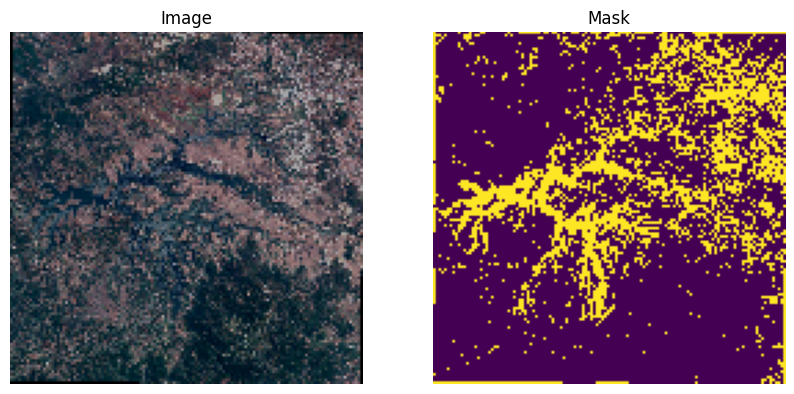

In [8]:
normalized_image = (images[0] - 6.0) / (255.0 - 6.0)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.clip(normalized_image, 0, 1))
plt.axis('off')
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(np.clip(masks[0], 0, 1))
plt.axis('off')
plt.title("Mask")

plt.show()

In [9]:

# Normalize images and masks
images = images / 255.0
masks = masks / 255.0

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


## U-Net Implementation

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Encoder (downsampling path)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (upsampling path)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [11]:
model = unet_model()

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=1)


I0000 00:00:1752472348.886057    6761 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2160 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/3


I0000 00:00:1752472351.929619    6877 service.cc:152] XLA service 0x715a84002360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752472351.929647    6877 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-07-14 07:52:32.001573: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752472352.508221    6877 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/2272 ━━━━━━━━━━━━━━━━━━━━ 1:06 29ms/step - accuracy: 0.4882 - loss: 0.7001

I0000 00:00:1752472357.827522    6877 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2272/2272 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.6453 - loss: 0.5681 - val_accuracy: 0.6726 - val_loss: 0.6229
Epoch 2/3
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - accuracy: 0.6909 - loss: 0.5021 - val_accuracy: 0.6663 - val_loss: 0.4733
Epoch 3/3
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 73s 32ms/step - accuracy: 0.6933 - loss: 0.4880 - val_accuracy: 0.7502 - val_loss: 0.4235


## Plotting Model's Loss and Accuracy

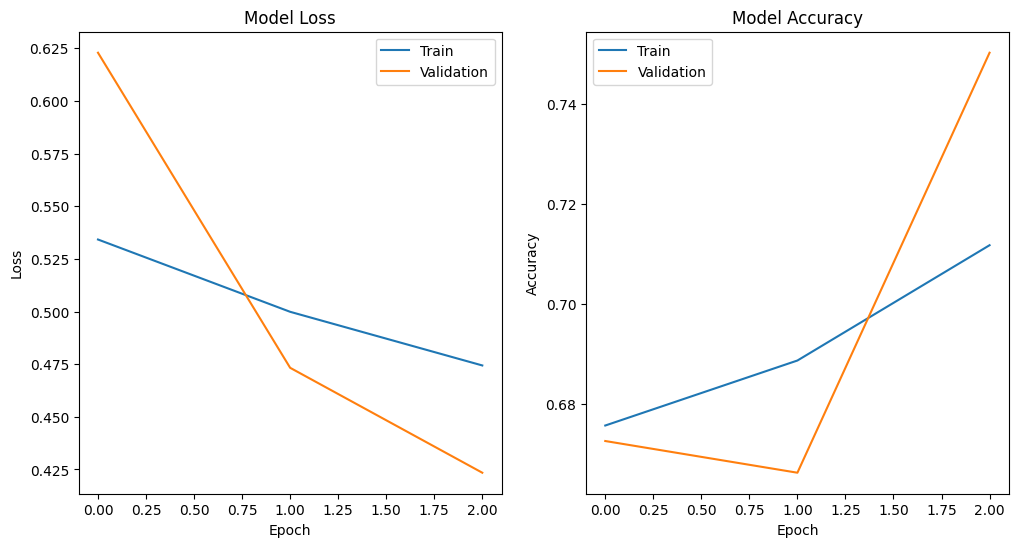

In [12]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [13]:
# predictions = model.predict(X_val)
predictions = model.predict(X_val, batch_size=1)

569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


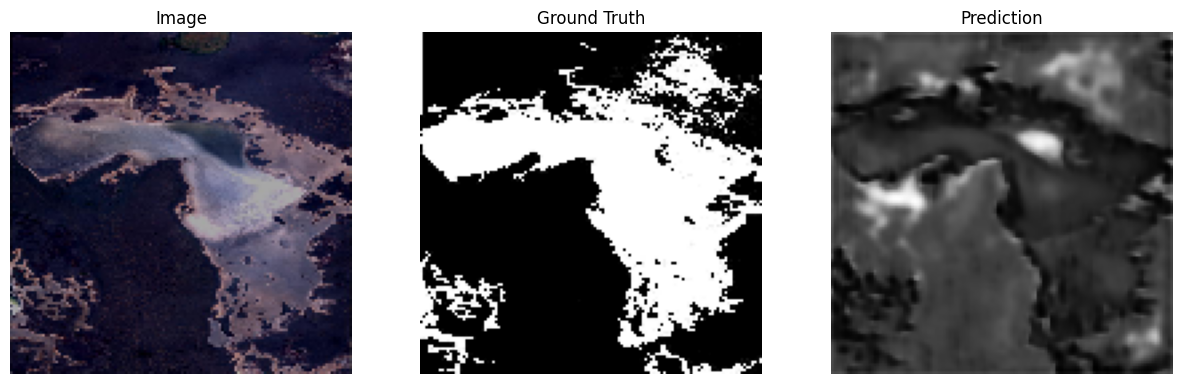

In [14]:
def plot_image_groundtruth_prediction(image, groundtruth, prediction, index):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image[index])
    plt.axis('off')
    plt.title('Image')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(groundtruth[index].squeeze(),cmap='gray')  
    plt.axis('off')
    plt.title('Ground Truth')

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(prediction[index].squeeze(),cmap='gray')  
    plt.axis('off')
    plt.title('Prediction')

    plt.show()

# Sample
plot_image_groundtruth_prediction(X_val, y_val, predictions, index=0)

## Data Augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator 
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen.fit(X_train)


In [16]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=1),
                    validation_data=(X_val, y_val),
                    epochs=3)

Epoch 1/3


/home/starlink/bxhu/sic-unet-sat/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2272/2272 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - accuracy: 0.6419 - loss: 0.5947 - val_accuracy: 0.7033 - val_loss: 0.5096
Epoch 2/3
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 71s 31ms/step - accuracy: 0.6595 - loss: 0.5660 - val_accuracy: 0.7370 - val_loss: 0.4861
Epoch 3/3
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 71s 31ms/step - accuracy: 0.6589 - loss: 0.5695 - val_accuracy: 0.7018 - val_loss: 0.5092


## Predict with Data Augmentation

In [17]:
def predict_with_augmentation(model, datagen, X_val, y_val, index=0):
    # Create a batch generator for the validation data
    augmented_generator = datagen.flow(X_val, batch_size=1, shuffle=False)
    
    # Get augmented image and mask
    augmented_image = next(augmented_generator)[0]
    
    # Make predictions
    predictions = model.predict(np.expand_dims(augmented_image, axis=0))
    
    return augmented_image, y_val[index], predictions[0]

# Example usage
augmented_image, groundtruth, prediction = predict_with_augmentation(model, datagen, X_val, y_val, index=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


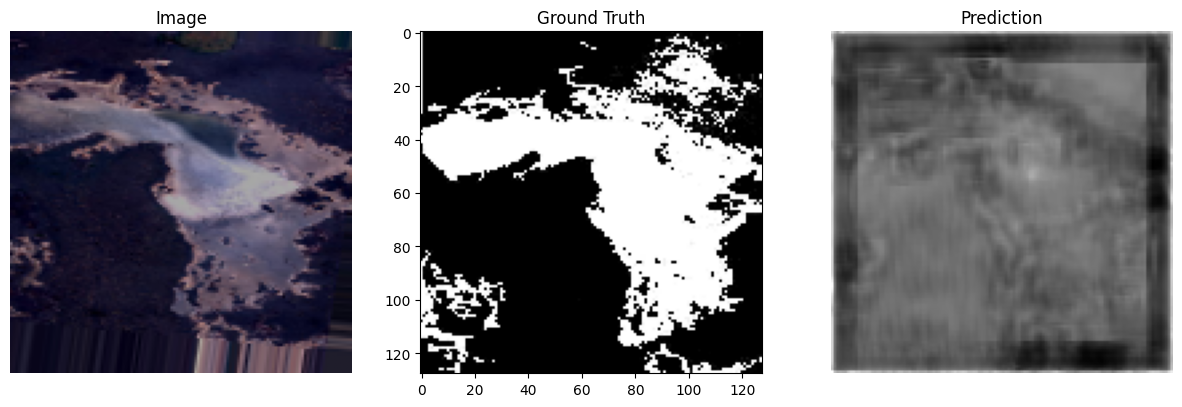

In [18]:
def plot_image_groundtruth_prediction(image, groundtruth, prediction):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Image')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(groundtruth.squeeze(), cmap='gray')  
    plt.title('Ground Truth')

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(), cmap='gray')  
    plt.axis('off')
    plt.title('Prediction')

    plt.show()

# Example usage
plot_image_groundtruth_prediction(augmented_image, groundtruth, prediction)


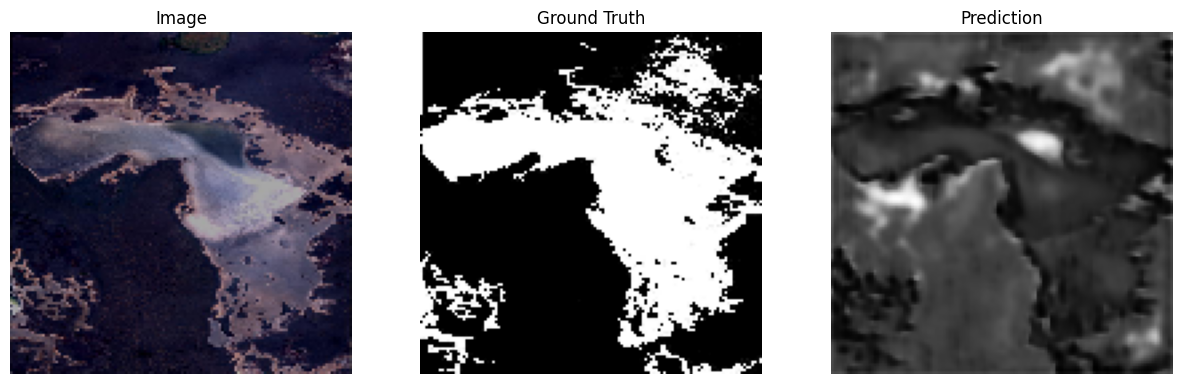

In [19]:
import matplotlib.pyplot as plt

def plot_image_groundtruth_prediction(images, groundtruths, predictions, index):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(images[index])
    plt.axis('off')
    plt.title('Image')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(groundtruths[index].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth')

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[index].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Prediction')

    plt.show()

# Example usage
plot_image_groundtruth_prediction(X_val, y_val, predictions, index=0)


In [20]:
import matplotlib.pyplot as plt
import os

# --- Best Practice: Ensure the output directory exists ---
output_dir = './output/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# ---------------------------------------------------------

def plot_image_groundtruth_prediction(images, groundtruths, predictions, index):
    # Create a new figure for each plot
    fig = plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(images[index])
    plt.axis('off')
    plt.title('Image')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(groundtruths[index].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth')

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[index].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Prediction')
    
    # Save the figure to a file
    plt.savefig(os.path.join(output_dir, f"cmp-{index}.png"))
    
    # --- IMPORTANT: Close the figure to free up memory ---
    plt.close(fig)

# --- Your existing loop remains the same ---
for idx in range(len(X_val)):
    plot_image_groundtruth_prediction(X_val, y_val, predictions, index=idx)

print("All images have been saved.")

All images have been saved.
